## 데이콘 구내식당 식수인원 예측
### MAE 가 평가 지표! 

In [18]:
import numpy as np 
import pandas as pd 
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from nltk import word_tokenize, sent_tokenize
import nltk
import datetime
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 데이터 삽입

In [5]:
train_df= pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

sub = pd.read_csv('sample_submission.csv')

Test 데이터는 train 데이터와 동일한 변수들이 있으나, 중식계와 석식계가 빠져있음

        -> 중식계와 석식계가 예측 대상인 타겟이기 때문
        -> Train 데이터로 학습을 진행하고, test 데이터로 중식계와 석식계의 값을 예측한 csv 파일을 만들어 제출할 것

# 데이터 전처리

In [19]:
# 석식계가 0인 날 -> 전주 같은 요일의 석식계로 대체
train_df['석식계'] = train_df['석식계'].replace(0, np.NaN)
train_df['요일'].unique()
yoil = train_df['요일'].unique()
dfs = {y: train_df[train_df['요일'] == y] for y in yoil}

for y in yoil:
    dfs[y]['석식계'] = dfs[y]['석식계'].fillna(method = 'ffill')
    
    
train_df1 = pd.concat(dfs)
train_df1 = train_df1.droplevel(0)
train_df1 = train_df1.sort_index()

In [20]:
#전처리를 위해 train, test 를 합한 data 데이터프레임 생성
#조식메뉴 칼럼 삭제

data = pd.concat([train_df1,test_df])
data = data.reset_index(drop=True)
data = data.drop('조식메뉴',axis=1)

In [8]:
#메뉴 - 한글 토큰화
def tokenizer(s):
    s=re.sub(r'\([^)]*\) ','',s)
    s=re.sub('  ',' ',s)
    s=s.rstrip()
    return s.split(' ') 

In [9]:
#data['조식메뉴']=data['조식메뉴'].apply(tokenizer)
data['중식메뉴']=data['중식메뉴'].apply(tokenizer)
data['석식메뉴']=data['석식메뉴'].apply(tokenizer)

In [10]:
#출근자수 칼럼 추가
data['출근자수']=data['본사정원수']-data['본사출장자수']-data['본사휴가자수']-data['현본사소속재택근무자수']

In [11]:
#날짜 칼럼 세분화
data['일자'] = data['일자'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
data['요일'] = data['일자'].apply(lambda date: date.strftime('%a'))
import datetime as dt
data['일자'] = pd.to_datetime(data['일자'])
data['연'] = data['일자'].dt.year
data['월'] = data['일자'].dt.month
data['일'] = data['일자'].dt.day


In [12]:
#data

In [13]:
#공휴일 전날 식수가 줄어들 것으로 예상하여 공휴일전날 칼럼 생성

data['공휴일전날']=0

data['공휴일전날'][4]=1 #'16 설연휴
data['공휴일전날'][17]=1 #삼일절
data['공휴일전날'][47]=1 #국회의원 선거
data['공휴일전날'][62]=1 #어린이날
data['공휴일전날'][67]=1 #석가탄신일
data['공휴일전날'][152]=1 #추석연휴
data['공휴일전날'][245]=1 #'17 설연휴
data['공휴일전날'][264]=1 #'17 삼일절
data['공휴일전날'][309]=1 # 석가탄신일
data['공휴일전날'][310]=1 #'17 어린이날
data['공휴일전날'][330]=1 #'17 현충일
data['공휴일전날'][379]=1 #'17 광복절
data['공휴일전날'][502]=1 #'18 설연휴
data['공휴일전날'][510]=1 #'18 삼일절
data['공휴일전날'][552]=1 #'18 근로자의 날
data['공휴일전날'][555]=1 #'18 어린이날
data['공휴일전날'][565]=1 #'18 석가탄신일
data['공휴일전날'][575]=1 #'18 현충일
data['공휴일전날'][579]=1 #'18 지방선거
data['공휴일전날'][623]=1 #'18 광복절
data['공휴일전날'][650]=1 #'18 추석연휴
data['공휴일전날'][651]=1 #'18 한글날
data['공휴일전날'][705]=1 #'18 성탄절
data['공휴일전날'][709]=1 #'19 신정
data['공휴일전날'][732]=1 #'19 설연휴
data['공휴일전날'][748]=1 #'19 삼일절
data['공휴일전날'][790]=1 #'19 근로자의 날
data['공휴일전날'][814]=1 #'19 현충일
data['공휴일전날'][863]=1 #'19 광복절
data['공휴일전날'][882]=1 #'19 추석연휴
data['공휴일전날'][894]=1 #'19 개천절
data['공휴일전날'][897]=1 #'19 한글날
data['공휴일전날'][951]=1 #'19 성탄절
data['공휴일전날'][955]=1 #'20 신정
data['공휴일전날'][971]=1 #'20 설연휴
data['공휴일전날'][995]=1 #'20 삼일절
data['공휴일전날'][1027]=1 #'20 국회의원선거
data['공휴일전날'][1037]=1 #'20 석가탄신일
data['공휴일전날'][1038]=1 #'20 어린이날
data['공휴일전날'][1061]=1 #'20 현충일
data['공휴일전날'][1099]=1 #'20 광복절
data['공휴일전날'][1129]=1 #'20 추석연휴
data['공휴일전날'][1133]=1 #'20 한글날
data['공휴일전날'][1187]=1 #'20 성탄절

data['공휴일전날'][1215]=1 #'21 설연휴
data['공휴일전날'][1225]=1 #'21 삼일절

# EDA

In [14]:
#plt.figure(figsize=(8,5))

#sns.scatterplot(data['출근자수'], data['중식계'],hue=data['요일'])

#plt.show()

In [15]:
#plt.figure(figsize=(8,5))
#sns.scatterplot(data['본사시간외근무명령서승인건수'], data['석식계'],hue=data['요일'])
#

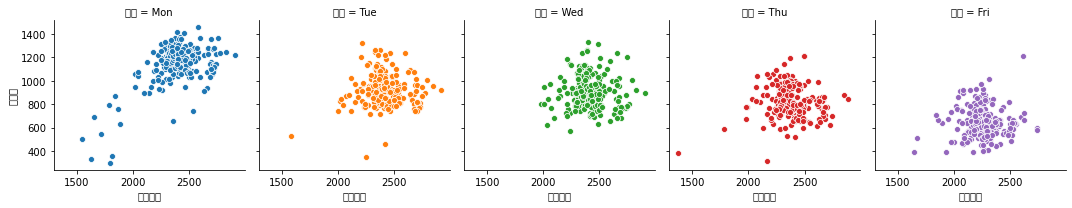

In [16]:
#요일별 출근자수와 중식계의 scatterplot 

grid = sns.FacetGrid(data=data, col='요일', hue = '요일')
grid.map(sns.scatterplot, '출근자수', '중식계')




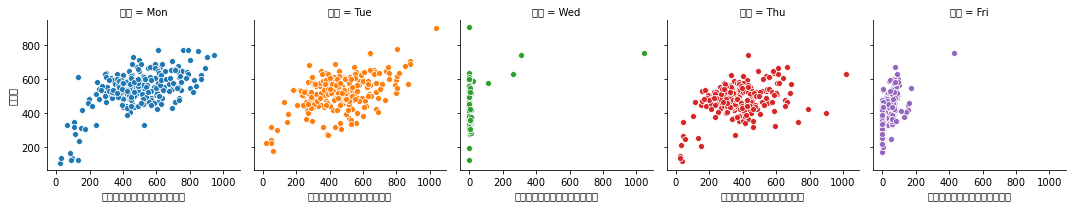

In [17]:
#요일별 야근자수와 석식계의 scatterplot 


grid = sns.FacetGrid(data=data, col='요일', hue = '요일')
grid.map(sns.scatterplot, '본사시간외근무명령서승인건수', '석식계')

#수요일 금요일에 야근자 수가 0인 날이 많은 것을 확인

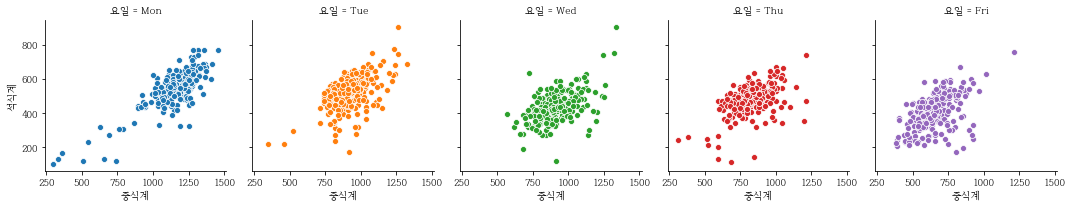

In [16]:
#요일별 중식계와 석식계의 scatterplot 

grid = sns.FacetGrid(data=data, col='요일', hue = '요일')
grid.map(sns.scatterplot, '중식계', '석식계')


In [17]:
#data[(data['석식계']==0) & (data['요일']=='Wed')]

In [18]:
wen=['2020-03-25','2020-04-29','2020-05-27','2020-06-24','2020-07-29','2020-08-26','2020-09-30','2020-10-28','2020-12-30']

data[data['일자'].isin(wen)]


#val=['2016-02-14','2017-02-14','2018-02-14','2019-02-14','2020-02-14']
#data[data['일자'].isin(val)]


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,출근자수,연,월,일,공휴일전날
1013,2020-03-25,Wed,2950,122,146,1,303.0,"[쌀밥/잡곡밥, 유부주머니국, 목살스테이크, 파스타샐러드, 오이무침, 포기김치]","[찹쌀밥, 장각닭죽, 생야채*쌈짱, 오렌지, 하루야채주스, 포기김치]",1022.0,526.0,2379.0,2020,3,25,0
1037,2020-04-29,Wed,2962,221,250,0,396.0,"[새우날치알볶음밥, 쌀국수, 장어구이*소스, 춘권튀김*칠리드레질, 오이무초무침, 망...","[쌀밥/잡곡밥, 홍합무우국, 로제찜닭*마늘빵, 계란장조림, 숙주미나리무침, 연근흑임...",680.0,192.0,2095.0,2020,4,29,1
1054,2020-05-27,Wed,2962,65,234,2,235.0,"[곤드레밥*양념장, 무채국, 꽁치한마리구이, 만두탕수육, 쨔샤이무침, 열무김치]","[쌀밥/잡곡밥, 도토리묵냉국, 돼지갈비찜, 감자프리타타, 오이도라지무침, 포기김치]",704.0,339.0,2428.0,2020,5,27,0
1087,2020-07-29,Wed,2997,256,233,11,150.0,"[쌀밥/흑미밥/찰현미밥, 우거지국, 삼겹살수육, 모둠쌈*쌈장, 풋고추/마늘*새우젓,...","[흑미밥, 참치파개장, 오징어불고기, 이색전(가지,애호박)*양념장, 생깻잎지, 포기김치]",871.0,280.0,2358.0,2020,7,29,0
1106,2020-08-26,Wed,2989,215,197,2,363.0,"[쌀밥/흑미밥/찰현미밥, 나주곰탕, 적어구이&양념장, 한식잡채, 얼갈이나물, 석박지...","[흑미밥, 냉메밀소바, 돈육가지두반장볶음, 새우튀김*크림소스, 연두부*양념장, 포기김치]",897.0,495.0,2214.0,2020,8,26,0
1146,2020-10-28,Wed,3008,105,287,3,138.0,"[쌀밥/흑미밥/찰현미밥, 삼계탕, 고기완자전, 방풍나물, 채소스틱&쌈장/석박지, (...","[흑미밥, 사골옹심이만둣국, 스태프핫도그, 가자미양념찜, 쪽파김무침, 포기김치]",791.0,293.0,2478.0,2020,10,28,0


#### 2020년 부터 자기 계발의 날이 없어진 것 같다.

# climate 데이터 삽입

https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&openPopup=Y

기상청 진주시 날씨 - 강수량 , 최고온도 


2016-02-01 ~~ 2020-04-09

강수 기준으로 정한 링크
https://tagilog.tistory.com/711

import os
path = './날씨/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')] 
climate = pd.DataFrame()
for i in file_list_py:
    cl = pd.read_csv(path + i)
    climate = pd.concat([climate,cl])
    


#climate

### climate
#### temp - 기온
#### datetime - 날짜시간
#### rain - 강수량
#### rain_qc - 9:결측치 
#### snow - 적설량

##### 점심시간 저녁시간의 날씨가 구내식당 식수에 영향을 줄 것이라는 생각에 가져온 기상청 날씨 데이터




import datetime
import datetime as dt
climate['datetime'] = pd.to_datetime(climate['datetime'])
climate['연'] = climate['datetime'].dt.year
climate['월'] = climate['datetime'].dt.month
climate['일'] = climate['datetime'].dt.day

climate['시간'] = climate['datetime'].dt.time
climate['일자'] = climate['datetime'].apply(lambda date: datetime.datetime.strftime(date,'%Y-%m-%d'))

climate['rain'] = climate['rain'].replace(np.NaN, 0)
#climate[climate['rain_qc']==9]['rain']=climate[climate['rain_qc']==9]['rain'].replace(0, np.NaN)
#climate['rain']=climate['rain'].fillna(method = 'ffill')

#강수량 결측값 위의 값으로 대체
climate['rain'] = np.where(climate['rain_qc']==9,np.NaN,climate['rain'])
climate['rain']=climate['rain'].fillna(method = 'ffill')

#점심시간 11~1 / 저녁시간 5~7 만 남기고 삭제
climate = climate[climate['시간'].isin([datetime.time(11, 0), datetime.time(12, 0),
       datetime.time(13, 0),datetime.time(17, 0), datetime.time(18, 0),
       datetime.time(19, 0)])]

climate['what'] = np.where(climate['시간'].isin([datetime.time(11, 0), datetime.time(12, 0), datetime.time(13, 0)]),'점심','저녁')

climate1=climate.groupby(['일자','what']).mean()

climate1=climate1.drop(['rain_qc','연','월','일'],axis=1)

unstacked = climate1.unstack()
unstacked = unstacked.reset_index()
#unstacked.rename(columns={(  '일자',   ''):'일자',('temp', '저녁'):'temp_저녁', ('temp', '점심'):'temp_점심',('rain', '저녁'):'rain_저녁',('rain', '점심'):'rain_점심',('snow', '저녁'):'snow_저녁',('snow', '점심'):'snow_점심'}, inplace=True)


climate2 = pd.DataFrame(index=range(0,1890))
climate2['일자']=unstacked[(  '일자',   '')]
climate2['temp_저녁']=unstacked[('temp', '저녁')] 
climate2['temp_점심']=unstacked[('temp', '점심')]
climate2['rain_저녁']=unstacked[('rain', '저녁')]
climate2['rain_점심']=unstacked[('rain', '점심')]
#climate2['snow_저녁']=unstacked[('snow', '저녁')]
#climate2['snow_점심']=unstacked[('snow', '점심')]


#climate['폭염'] = climate['high_temp'].apply(lambda x : 1 if x > 30 else 0)
#climate['강수'] = climate['rain'].apply(lambda x : 1 if x > 25 else 0)

climate2

#climate['date'] = climate['date'].apply(lambda date: date.strftime('%Y-%m-%d'))
#climate2['일자']
#data['일자']

In [19]:
climate= pd.read_csv('./climate.csv')
climate

,date,mean_temp,high_temp,rain
0,2016-02-01,-0.6,5.0,NaN
1,2016-02-02,-2.3,6.2,NaN
2,2016-02-03,-1.7,7.7,NaN
3,2016-02-04,-0.2,7.7,NaN
4,2016-02-05,1.3,9.6,NaN
...,...,...,...,...
1890,2021-04-05,10.5,17.8,NaN
1891,2021-04-06,11.3,21.1,NaN
1892,2021-04-07,13.3,22.7,NaN
1893,2021-04-08,12.9,21.8,NaN


In [20]:
climate['폭염'] = climate['high_temp'].apply(lambda x : 1 if x > 30 else 0)
climate['강수'] = climate['rain'].apply(lambda x : 1 if x > 10 else 0)

# 데이터셋 합하기

In [21]:
#train_df['일자'] = train_df['일자'].apply(lambda date: str(date))
data['일자'] = data['일자'].apply(lambda date: date.strftime('%Y-%m-%d'))
#climate2['일자'] = climate2['일자'].apply(lambda date: date.strftime('%Y-%m-%d'))

#data['일자'] = data['일자'].apply(lambda date: str(date))
#climate2['일자'] = climate2['일자'].apply(lambda date: str(date))

In [22]:
mymy = pd.merge(data, climate, left_on = '일자', right_on = 'date' , how = 'left')

mymy = mymy.drop(['date','mean_temp','high_temp','rain'], axis=1)

In [23]:
#mymy.to_csv('totaldata.csv')

In [24]:
#mymy = mymy.drop([], axis=1)

In [25]:
#mymy=mymy.fillna(0)
#mymy['폭염'] = mymy['폭염'].apply(lambda x: int(x))
#mymy['강수'] = mymy['강수'].apply(lambda x: int(x))
#mymy['중식계'] = mymy['중식계'].apply(lambda x: int(x))
#mymy['석식계'] = mymy['석식계'].apply(lambda x: int(x))
#mymy['출근자수'] = mymy['출근자수'].apply(lambda x: int(x))

In [26]:
#mymy[mymy['강수']==1]

In [27]:
#grid = sns.FacetGrid(data=mymy, col='요일')
#grid.map(sns.scatterplot, 'rain_점심', '중식계')

In [28]:
#grid = sns.FacetGrid(data=mymy, col='요일')
#grid.map(sns.scatterplot, 'rain_저녁', '석식계')

In [29]:
#grid = sns.FacetGrid(data=mymy, col='요일')
#grid.map(sns.scatterplot, 'temp_점심', '중식계')

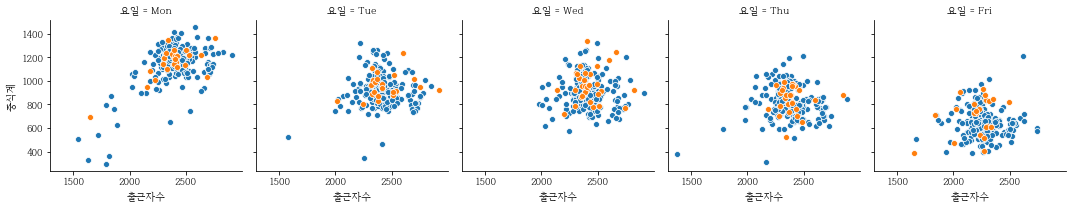

In [30]:
grid = sns.FacetGrid(data=mymy, col='요일',hue = '강수')
grid.map(sns.scatterplot, '출근자수', '중식계')

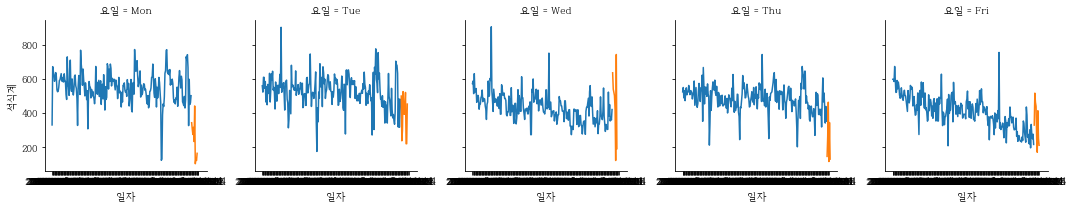

In [31]:
grid = sns.FacetGrid(data=mymy, col='요일', hue = '공휴일전날')
grid.map(plt.plot, '일자', '석식계')

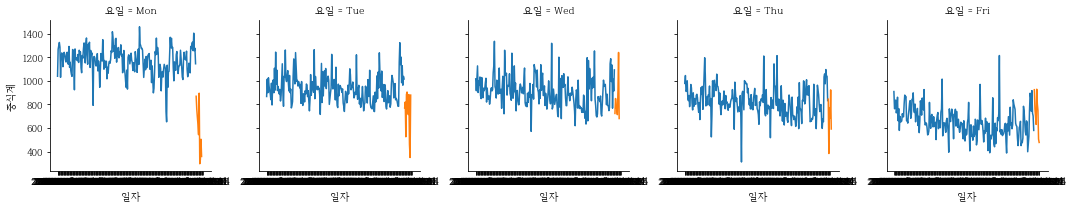

In [32]:
grid = sns.FacetGrid(data=mymy, col='요일', hue = '공휴일전날')
grid.map(plt.plot, '일자', '중식계')

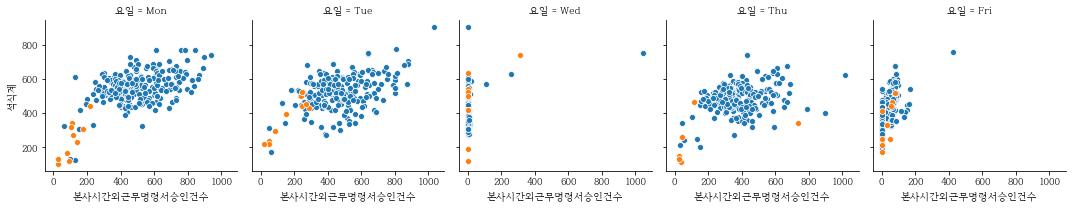

In [33]:
grid = sns.FacetGrid(data=mymy, col='요일', hue = '공휴일전날')
grid.map(sns.scatterplot, '본사시간외근무명령서승인건수', '석식계')


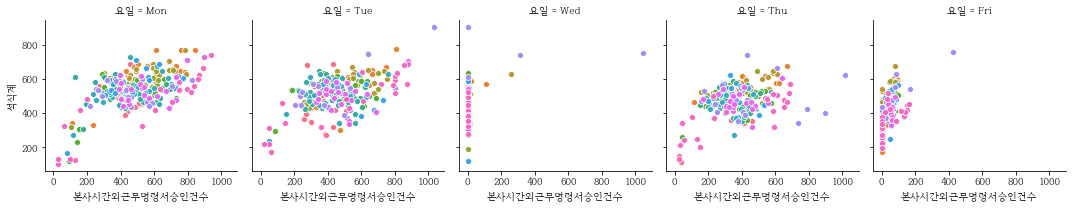

In [34]:
grid = sns.FacetGrid(data=mymy, col='요일', hue = '월')
grid.map(sns.scatterplot, '본사시간외근무명령서승인건수', '석식계')


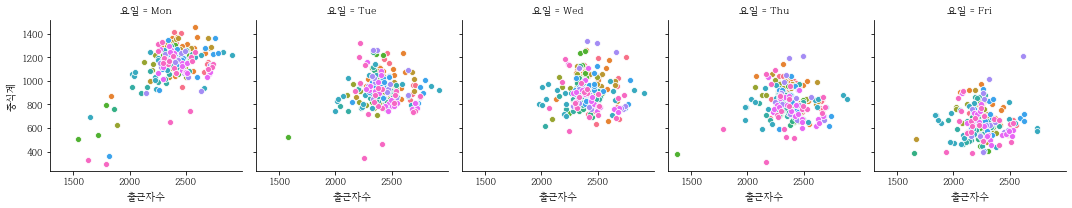

In [35]:
grid = sns.FacetGrid(data=mymy, col='요일', hue = '월')
grid.map(sns.scatterplot, '출근자수', '중식계')

# 모델링

In [36]:
mymy = pd.get_dummies(mymy,columns=['요일'] )

In [37]:
train = mymy[0:1204]
test = mymy[1205:]
train = train.replace(np.NaN,0)

In [38]:
x_lun = train.drop(['일자','석식계','중식계','중식메뉴','석식메뉴','일','강수','폭염'],axis=1)
y_lun = train['중식계']

x_din = train.drop(['일자','석식계','중식계','중식메뉴','석식메뉴','일','강수','폭염'],axis=1)
y_din = train['석식계']

test_pred = test.drop(['일자','석식계','중식계','중식메뉴','석식메뉴','일','강수','폭염'],axis=1)

In [40]:
x_lun

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,출근자수,연,월,공휴일전날,요일_Fri,요일_Mon,요일_Thu,요일_Tue,요일_Wed
0,2601,50,150,238,0.0,2401.0,2016,2,0,0,1,0,0,0
1,2601,50,173,319,0.0,2378.0,2016,2,0,0,0,0,1,0
2,2601,56,180,111,0.0,2365.0,2016,2,0,0,0,0,0,1
3,2601,104,220,355,0.0,2277.0,2016,2,0,0,0,1,0,0
4,2601,278,181,34,0.0,2142.0,2016,2,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2983,62,176,508,372.0,2373.0,2021,1,0,0,0,0,1,0
1200,2983,75,198,4,391.0,2319.0,2021,1,0,0,0,0,0,1
1201,2983,92,231,462,351.0,2309.0,2021,1,0,0,0,1,0,0
1202,2983,255,248,1,303.0,2177.0,2021,1,0,1,0,0,0,0


In [39]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, random_state=42,criterion='mae')
forest.fit(x_lun, y_lun)

RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=42)

In [41]:
sub.iloc[:,1] = forest.predict(test_pred)



In [42]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, random_state=42,criterion='mae')
forest.fit(x_din, y_din)

RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=42)

In [43]:
sub.iloc[:,2] = forest.predict(test_pred)

In [72]:
sub.to_csv('toto_try.csv',index=False)

In [44]:
sub

,일자,중식계,석식계
0,2021-01-27,1040.37,399.91
1,2021-01-28,1020.68,391.19
2,2021-01-29,585.88,251.04
3,2021-02-01,1190.56,482.28
4,2021-02-02,1042.01,398.99
5,2021-02-03,1028.90,434.37
6,2021-02-04,992.60,445.50
7,2021-02-05,636.48,356.20
8,2021-02-08,1276.10,627.95
9,2021-02-09,1057.72,478.01
